# Imports


## Import python packages, install tested tensorflow version and grant access to your google drive (for dataset)

### Tests if mounting google drive is possible to determine if the code is run on google collab (GOOGLE=TRUE)

In [0]:
try:
    GOOGLE = True
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=1)
    #list files in linked google drive
except:
    GOOGLE = False

Mounted at /content/gdrive


In [0]:
if GOOGLE:
    !pip install tensorflow==1.13.1

In [0]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import keras
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
#usefule auxiliary functions:
flatten = lambda x: [y for z in x for y in z]

## Load test and validation set


### Set paths (Make sure to upload the test set to your google drive or generate it here) 
### Set maximum sequence length + number of different AAs considered



In [0]:
if GOOGLE:
    baseFolder = '/content/gdrive/My Drive/'
else:
    baseFolder = 'CHANGE TO YOUR LOCAL DIRECTORY/'
dataSetFolder = baseFolder + 'DeeProtein2/Datasets/'
model_saves_folder_location = baseFolder + 'DeeProtein2/Models/'
fig_saves_folder_location = baseFolder + 'DeeProtein2/Figures/'
SEQUENCE_LEN = 650 #max. number of AAs in sequence (needed for reshaping imported numpy array)
CLASSES = 21 #number of different AAs considered; now that sequences with non cannonical AAs removed there are 20 left + "0" encoding "None" 


In [0]:
if not os.path.exists(model_saves_folder_location):
    if GOOGLE:
        drive.mount('/content/drive/', force_remount=True)
    os.mkdir(model_saves_folder_location)
if not os.path.exists(fig_saves_folder_location):
    if GOOGLE:
        drive.mount('/content/drive/', force_remount=True)
    os.mkdir(fig_saves_folder_location)

In [0]:
def FldToShell(txt):
    #converts space to '\ ' to use filepath in shell commands
    return txt.replace(' ','\ ')
!ls {FldToShell(baseFolder)}

'Colab Notebooks'   DeeProtein2   IGEM	 MMSeqs


### Importing training and validation sets as numpy arrays


### Filter data sets (optional)

In [0]:
FILTERCHILDREN = False #default: False, assumes 
CREATE_FILTERCHILDREN = True
if FILTERCHILDREN:
    numTrainPerTerm = 70 #number of training sequences per term  
    numValidPerTerm = 30 #number of validation sequences per term
    try:
        CREATE_FILTERCHILDREN = False #FIX: default:False
        X_train = np.load(dataSetFolder+'X_train_children.npy', allow_pickle=True)
        y_train = np.load(dataSetFolder+'y_train_children.npy', allow_pickle=True)
        X_test = np.load(dataSetFolder+'X_test_children.npy', allow_pickle=True)
        y_test = np.load(dataSetFolder+'y_test_children.npy', allow_pickle=True)
    except:
        print('couldnt load filtered set; should create')

### Load data sets if haven't loaded the already previously filtered validation/training set

In [0]:
if not FILTERCHILDREN or (CREATE_FILTERCHILDREN and FILTERCHILDREN): 
    trainSetX = 'TestSetX.npy'
    trainSetY = 'TestSetY.npy'
    validSetX = 'ValidSetX.npy'
    validSetY = 'ValidSetY.npy'
    X_train = np.load(dataSetFolder+trainSetX, allow_pickle=True)
    y_train = np.load(dataSetFolder+trainSetY, allow_pickle=True)
    X_test = np.load(dataSetFolder+validSetX, allow_pickle=True)
    y_test = np.load(dataSetFolder+validSetY, allow_pickle=True)

FileNotFoundError: ignored

### Filter out all terms with children

In [0]:
if FILTERCHILDREN and CREATE_FILTERCHILDREN:
    usedTerms = np.load(dataSetFolder + '../usedTerms.npy')
    if GOOGLE:
        # the library goatools gives easy access to hierarchical structure of the go terms; https://github.com/tanghaibao/goatools 
        !pip install goatools 
    godagFile = baseFolder + '/DeeProtein2/go-basic.obo' #file downloaded from http://purl.obolibrary.org/obo/go/go-basic.obo


In [0]:
if FILTERCHILDREN and CREATE_FILTERCHILDREN:
    #load file to check for children of terms
    GODagTerms = GODag(godagFile, optional_attrs=['relationship'])

    nIt = 0
    sizeBeg = 1
    children = []
    while np.size(children) != sizeBeg or nIt > 100:
        sizeBeg = np.size(children)
        for term in usedTerms:
            if not any(x in children for x in GODagTerms[term].get_all_children()):
                if term not in children:
                    children.append(term)
            elif term in children:
                children.remove(term)
        nIt += 1
    if nIt > 100:
        print('Couldnt find children!')

In [0]:
if FILTERCHILDREN and CREATE_FILTERCHILDREN:
    #convert labels to numbers relative to usedTerms list
    numberChildren = [i for i,x in enumerate(usedTerms) if x in children ]
    print('We found %g terms without children in the dataset of %g terms' %(len(numberChildren), len(usedTerms)))
    print('shape X_test: ',np.shape(X_test), 'shape y_test: ', np.shape(y_test))
    print('shape X_train: ',np.shape(X_train), 'shape y_train: ', np.shape(y_train))

In [0]:
if FILTERCHILDREN and CREATE_FILTERCHILDREN:
    #only include representatives of children terms
    y_test_children = np.array(flatten([y_test[i*numValidPerTerm:numValidPerTerm*i+numValidPerTerm] for i in numberChildren]))
    y_train_children = np.array(flatten([y_train[numTrainPerTerm*i:numTrainPerTerm*i+numTrainPerTerm] for i in numberChildren]))
    print('shape y_train_children: ',np.shape(y_train_children), 'shape y_test_children: ', np.shape(y_test_children), 'total:', np.shape(y_train_children)[0]+np.shape(y_test_children)[0])

In [0]:
if FILTERCHILDREN and CREATE_FILTERCHILDREN:
    #only include terms given in numberChildren
    y_train_children = np.array([[x for x in y if x in numberChildren] for y in y_train_children])
    y_test_children = np.array([[x for x in y if x in numberChildren] for y in y_test_children])
    print('shape y_train_children: ',np.shape(y_train_children), 'shape y_test_children: ', np.shape(y_test_children), 'total:', np.shape(y_train_children)[0]+np.shape(y_test_children)[0])

In [0]:
if FILTERCHILDREN and CREATE_FILTERCHILDREN:
    #only include representatives of children terms x_values
    X_test_children = np.array(flatten([X_test[numValidPerTerm*i:i*numValidPerTerm+numValidPerTerm] for i in numberChildren]))
    X_train_children = np.array(flatten([X_train[numTrainPerTerm*i:i*numTrainPerTerm+numTrainPerTerm] for i in numberChildren]))
    print('shape X_train_children: ',np.shape(X_train_children), 'shape X_test_children: ', np.shape(X_test_children), 'total:', np.shape(X_train_children)[0]+np.shape(X_test_children)[0])

In [0]:
if FILTERCHILDREN and CREATE_FILTERCHILDREN:
    sizesChildren = [np.size(x) for x in y_test_children]
    sizes = [np.size(x) for x in y_test]
    print('TESTSET: Children sequences have maximum labels of ',max(sizesChildren),'and minimum labels ', min(sizesChildren),'with an average of ', np.average(sizesChildren),'labels per sequence, compared to ',np.average(sizes),'for the whole dataset')
    sizesChildren = [np.size(x) for x in y_train_children]
    sizes = [np.size(x) for x in y_train]
    print('TRAININGSET: Children sequences have maximum labels of ',max(sizesChildren),'and minimum labels ', min(sizesChildren),'with an average of ', np.average(sizesChildren),'labels per sequence, compared to ',np.average(sizes),'for the whole dataset')

In [0]:
if FILTERCHILDREN and CREATE_FILTERCHILDREN:
    np.save(dataSetFolder+'y_test_children', y_test_children)
    np.save(dataSetFolder+'y_train_children', y_train_children)
    np.save(dataSetFolder+'X_test_children', X_test_children)
    np.save(dataSetFolder+'X_train_children', X_train_children)
    #rename training/validation set
    X_train = X_train_children
    y_train = y_train_children
    X_test = X_test_children
    y_test = y_test_children

# Training

In [0]:
print('shape X_test: ',np.shape(X_test), 'shape y_test: ', np.shape(y_test))
print('shape X_train: ',np.shape(X_train), 'shape y_train: ', np.shape(y_train))

shape X_test:  (86430, 650) shape y_test:  (86430,)
shape X_train:  (201670, 650) shape y_train:  (201670,)


In [0]:
print('unique labels in y_test:',len(np.unique(flatten(y_test))),'y_train:',len(np.unique(flatten(y_train))),'X_test:',len(np.unique(flatten(X_test))),'X_train:',len(np.unique(flatten(X_train))),)

unique labels in y_test: 1550 y_train: 1550 X_test: 21 X_train: 21


### Convert term numbers to binary representation


In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer() #uses int64 as default: use memory mark (no fix found)
# y_train = np.array([np.array(x, dtype=np.int16) for x in y_train])
mlb.fit(y_train)
print('transform labels into ', len(mlb.classes_), 'unique binary classes')

transform labels into  2881 unique binary classes


In [0]:
y_train = mlb.transform(y_train)
y_test = mlb.transform(y_test)
print('shape y_test: ',np.shape(y_test), 'shape y_train: ', np.shape(y_train))

shape y_test:  (86430, 2881) shape y_train:  (201670, 2881)


## Definitions of training functions

In [0]:
def OneHotTfKeras(input_dim=None, input_length=None, reverse=False, dtype=tf.int16, machineType='CPU'):
    if machineType == 'TPU':
        dtype = tf.int32
    # Check if inputs were supplied correctly
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    # Helper method that uses the tensorflow one_hot encoder
    def _one_hot(seq, inp_num_classes):
    # one_hot is consistent: uses the int as the index where the 1 is
    # "nothing" is encoded as one category as well => +1 category 
    # int32 important for TPUs
        if reverse:
            return tf.keras.backend.one_hot(tf.cast(tf.reverse(seq,[-1]), dtype), num_classes=inp_num_classes)
        return tf.keras.backend.one_hot(tf.cast(seq, dtype), num_classes=inp_num_classes)

    # Final layer representation as a Lambda layer
    return tf.keras.layers.Lambda(_one_hot, arguments={'inp_num_classes': input_dim}, input_shape=(input_length,))

In [0]:
def train_regression(model, model_save_loc, X_train, y_train, X_test, y_test, batch_size=2048, epochs=2, save_best_only=True, period=1, train_patience=100, weight_location=None, machineType='TPU', onlyLoadWeights=False):
    '''Main function for training
    model (tf.keras.Model): expects keras model to train on
    model_save_loc (path/filename.hdf5): filepath to save weights in .hdf5 format
    X_train (np.array): Training set; N sequences (AAs converted to integers) with length SEQUENCE_LEN (filled up with 0's if less AAs) in numpy array with shape (N,SEQUENCE_LEN)
    y_train (np.array): Training set; the binarized M labels (using sklearn.preprocessing.MultiLabelBinarizer) of N sequences in numpy array with shape (N,M)
    X_test (np.array): Validation set; L sequences (AAs converted to integers) with length SEQUENCE_LEN (filled up with 0's if less AAs) in numpy array with shape (L,SEQUENCE_LEN)
    y_test (np.array): Validation set; the binarized M labels (using sklearn.preprocessing.MultiLabelBinarizer) of L sequences in numpy array with shape (L,M)
    batch_size (int):
    epochs (int): number of training epochs
    save_best_only (bool): only save model/weights if found better one than already saved
    period: Interval (number of epochs) between checkpoints 
    train_patience (int): stopping when "no longer improving" "for at least train_patience epochs"
    weight_location (path/filename.hdf5): filepath to weights loaded prior to training, training will procede from weights
    machineType ('TPU','CPU','GPU'): determine machine to run training on
    onlyLoadWeights (bool): no training, will only load weights from weight_location; used to predict values 
    '''
    print("Batch size: {} (this corresponds to {} on GPUs)".format(batch_size,batch_size//8))
    print("Epochs: ", epochs)
    print("Patience: ", train_patience)
    print("Period: ", period)
    print("Save best only: ",save_best_only)
    print("Model save location: ",model_save_loc)
    print("\n")

    if not os.path.isdir(os.path.dirname(model_saves_folder_location)):
        raise Exception('folder to save model %s does not exist!' %os.path.dirname(model_saves_folder_location))
    
    if weight_location is not None:
        if not os.path.isdir(os.path.dirname(weight_location)):
            raise Exception('folder to save model %s does not exist!' %os.path.dirname(weight_location))

    if machineType == 'TPU':
        TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
        tf.logging.set_verbosity(tf.logging.INFO)
        tf.keras.backend.clear_session()
        
        finalModel = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
    else:
        finalModel = model
        
    from keras.metrics import top_k_categorical_accuracy, cosine_proximity
    from sklearn.metrics import accuracy_score
    def top_5_accuracy(x, y):
      """Must be passed to `load_model` function in `keras` as a custom_object"""
      return top_k_categorical_accuracy(x, y, k=5)
    
    def acc_score(x, y):
      print(x)
      return accuracy_score(np.array(x), np.array(y))
    
    finalModel.compile(
      loss='binary_crossentropy', optimizer='adam', metrics=[cosine_proximity]
    )
    if os.path.exists(weight_location):
      finalModel.load_weights(weight_location)
      print('loaded loaded weights %s' %weight_location)
    else:
      print('couldnt load weights %s, assuming no initial weights!'%weight_location)
    if onlyLoadWeights:
        return finalModel, None
    #Configure how to save model and early stopping
    callbacks_list = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath=model_save_loc,
          save_weights_only=False,
          monitor='val_loss', 
          save_best_only=save_best_only,
          mode='auto',
          period=period),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       patience=train_patience, 
                                       mode='auto')
    ]

    history = finalModel.fit(X_train,
                        y_train,
                        validation_data=(X_test,y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks_list,
                        verbose=1)

    return finalModel, history

## Models

### Model 1: main model

In [0]:
#Main Model
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))
x_in = tf.keras.layers.Embedding(CLASSES, 21, input_length=SEQUENCE_LEN)(inputs)
# Embedding 21 for full input (no information loss)

'''
kernel_size 20/21 I was thinking that 20/21 inputs was one amino acid, because 
the embbeding basically makes a one hot encoding (might be wrong)

I wanted small first layers to train with a larger batchsize and to reduce computations

I also used padding 'same' because if the size is always reduced some information has to be either compressed or gets lost
'''

x = tf.keras.layers.Conv1D(128, 20, padding="same")(x_in)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 20, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x_pre = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.AveragePooling1D(2)(x_pre)
x = tf.keras.layers.Conv1D(128, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid_1 = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.AveragePooling1D(2)(x_mid_1)
x = tf.keras.layers.Conv1D(128, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
'''
Similar to the reasons for padding I chose to increase the filter size and 
data size before Pooling to allow more information to be transfered,
but this is just hypothetical
'''
x = tf.keras.layers.Conv1D(256, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid_2 = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.AveragePooling1D(2)(x_mid_2)
x = tf.keras.layers.Conv1D(256, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid_3 = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.AveragePooling1D(2)(x_mid_3)
x = tf.keras.layers.Conv1D(256, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid_4 = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.AveragePooling1D(2)(x_mid_4)
x = tf.keras.layers.Conv1D(512, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x_mid_5 = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.AveragePooling1D(2)(x_mid_5)
x = tf.keras.layers.Conv1D(512, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(1024, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(1024, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)


x_pre = tf.keras.layers.GlobalAveragePooling1D()(x_pre)
x_mid_1 = tf.keras.layers.GlobalAveragePooling1D()(x_mid_1)
x_mid_2 = tf.keras.layers.GlobalAveragePooling1D()(x_mid_2)
x_mid_3 = tf.keras.layers.GlobalAveragePooling1D()(x_mid_3)
x_mid_4 = tf.keras.layers.GlobalAveragePooling1D()(x_mid_4)
x_mid_5 = tf.keras.layers.GlobalAveragePooling1D()(x_mid_5)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.concatenate([x_pre,x_mid_1,x_mid_2,x_mid_3,x_mid_4,x_mid_5, x], axis=-1)

x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(len(mlb.classes_))(x)
x = tf.keras.layers.Activation("sigmoid")(x)

model1 = tf.keras.Model(inputs=inputs, outputs=x)
model1.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 650)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 650, 21)      441         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 650, 128)     53888       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 650, 128)     512         conv1d[0][0]                     
_____________________________________

### Model 2: resnet

In [0]:
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))
x = tf.keras.layers.Embedding(CLASSES, 21, input_length=SEQUENCE_LEN)(inputs)
# Embedding 21 for full input (no information loss)

# kernel_size 21 I was thinking that 21 inputs was one amino acid,
# because the embbeding basically makes a one hot encoding (might be wrong)
x = tf.keras.layers.Conv1D(128, 21)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(len(mlb.classes_))(x)
x = tf.keras.layers.Activation("sigmoid")(x)

model2 = tf.keras.Model(inputs=inputs, outputs=x,name='v2')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 650, 21)           441       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 630, 128)          56576     
_________________________________________________________________
batch_normalization_v1_20 (B (None, 630, 128)          512       
_________________________________________________________________
activation_22 (Activation)   (None, 630, 128)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 628, 128)          49280     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 628, 128)          512       
__________

### Model 3: small

In [0]:
#model is smaller but faster compared to Model 1
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))
x = tf.keras.layers.Embedding(CLASSES, 21, input_length=SEQUENCE_LEN)(inputs)
x = tf.keras.layers.Conv1D(128, 21)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(512, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(len(mlb.classes_))(x)
x = tf.keras.layers.Activation("sigmoid")(x)
model3 = tf.keras.Model(inputs=inputs, outputs=x,name='v2')
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 650, 21)           441       
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 630, 128)          56576     
_________________________________________________________________
batch_normalization_v1_37 (B (None, 630, 128)          512       
_________________________________________________________________
activation_40 (Activation)   (None, 630, 128)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 628, 128)          49280     
_________________________________________________________________
batch_normalization_v1_38 (B (None, 628, 128)          512       
__________

## Execute training function

In [0]:
#parameters for training
machineType = 'CPU'
if GOOGLE:
    machineType = 'TPU'
batch_size = 8000 #default best model 8000
epochs = 500 #default model 500
train_patience = 100
model_save_loc = model_saves_folder_location+"AllModel1Bat8000Ep500.hdf5"
weight_location = model_saves_folder_location+"AllModel1Bat8000Ep500.hdf5"

In [0]:
if GOOGLE:
    #somtimes remount necessary when cancelling training routine abruptly
    drive.mount('/content/gdrive', force_remount=1)

Mounted at /content/gdrive


In [0]:
model, history = train_regression(model1, model_save_loc, X_train, y_train, X_test, y_test, batch_size=batch_size, epochs=epochs, weight_location=weight_location, machineType=machineType, train_patience=train_patience)

Batch size: 8000 (this corresponds to 1000 on GPUs)
Epochs:  300
Patience:  300
Period:  1
Save best only:  True
Model save location:  /content/gdrive/My Drive/DeeProtein2/Models/AllModel1Bat8000Ep500.hdf5


INFO:tensorflow:Querying Tensorflow master (grpc://10.7.56.50:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13462140333700152100)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4286133762061842683)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6780116833007637799)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7226998992

KeyboardInterrupt: ignored

# Performance estimation

## Predict test values

### Load weights (if no prior training during session done)

In [0]:
#using same function only to load weights for predictions
location_weights_analzye = model_save_loc
location_weights_analzye = model_saves_folder_location+"AllModel1Bat8000Ep500.hdf5"
drive.mount('/content/gdrive', force_remount=1)
#usually assumes want to test performance with same machineType as training otherwise use cpu_model = tpu_model.sync_to_cpu() after loading the weights
model, history = train_regression(model1, None, X_train, y_train, X_test, y_test, batch_size=batch_size, epochs=epochs, weight_location=location_weights_analzye, machineType=machineType, onlyLoadWeights=True)

Mounted at /content/gdrive
Batch size: 8000 (this corresponds to 1000 on GPUs)
Epochs:  300
Patience:  100
Period:  1
Save best only:  True
Model save location:  None


INFO:tensorflow:Querying Tensorflow master (grpc://10.7.56.50:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13462140333700152100)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4286133762061842683)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6780116833007637799)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7226998992121409545)
INFO:tensorflow:*** Availabl

In [0]:
if machineType == 'TPU':
    print('original shape X_test', np.shape(X_test), 'y_test', np.shape(y_test))
    #if TPU was used to train the test set has to be divisible by 8
    NtoCut = int(np.shape(X_test)[0]%8)
    if NtoCut != 0:
        X_test = X_test[:-1*NtoCut]    
        y_test = y_test[:-1*NtoCut]
    print('new shape X_test', np.shape(X_test), 'y_test', np.shape(y_test))


original shape X_test (86424, 650) y_test (86424, 2881)
new shape X_test (86424, 650) y_test (86424, 2881)


### Predict probabilities for different go terms

In [0]:
y_prob = model.predict(X_test) 

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(4, 650), dtype=tf.float32, name='input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 12.15471601486206 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(3, 650), dtype=tf.float32, name='input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 3.146794557571411 secs


### Convert probabilites to predicted set of terms for every sequence setting the canonical probabiliy threshold of 0.5 

In [0]:
y_predict = np.zeros(np.shape(y_prob))
for i in range(np.shape(y_prob)[1]):
    y_predict[:,i] = np.array(y_prob[:,i]>0.5, dtype=int)

## Compute matrics

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

In [0]:
np.shape(X_test), np.shape(y_test), np.shape(y_prob), np.shape(y_predict)

((86424, 650), (86424, 2881), (86424, 2881), (86424, 2881))

In [0]:
drive.mount('/content/gdrive', force_remount=1)


Mounted at /content/gdrive


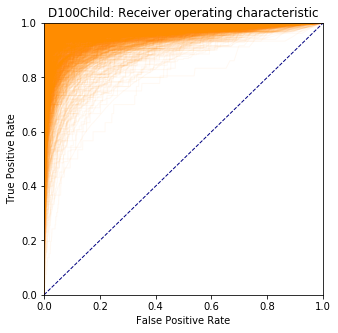

average auc 0.9777101247066277
looked at 2881 individual sequences


In [0]:
totalAuc = 0
N = np.shape(y_test)[1]
fig = plt.figure(figsize=(5, 5))
for i in range(N):
    fpr, tpr, thresholds = roc_curve(y_test[:,i], y_prob[:,i])
    roc_auc = auc(fpr, tpr)
    totalAuc += roc_auc
    plt.plot(fpr, tpr, color='darkorange', lw=1, alpha=0.05)#, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('D100: Receiver operating characteristic')
# plt.legend(loc="lower right")
plt.show("lower right")
fig.savefig(fig_saves_folder_location + 'AUCD100.png', dpi=450)
plt.show()
print('average auc', totalAuc/N)
print('looked at %g individual sequences'%N)

In [0]:
f1_score(y_test, y_predict, average='macro'), f1_score(y_test, y_predict, average='micro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.700674467873272, 0.8627907676380921)

In [0]:
print('predicted on average %g terms per sequence (actuale value: %g)' %(np.sum(y_predict)/np.shape(y_predict)[0], np.sum(y_test)/np.shape(y_test)[0]))

predicted on average 37.7934 terms per sequence (actuale value: 44.5139)


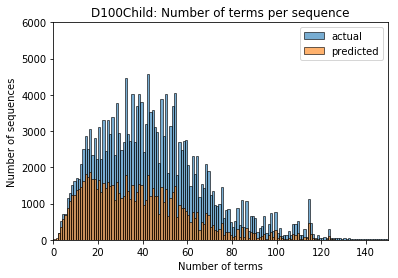

In [0]:
NTermsPerSeq_predicted = np.sum(y_predict, axis=1)
NTermsPerSeq = np.sum(y_train, axis=1)
bins = np.arange(0,np.max(flatten([NTermsPerSeq,NTermsPerSeq_predicted])))
fig = plt.figure()
plt.hist(NTermsPerSeq,bins=bins, alpha=0.6, label='actual', histtype='bar', ec='black');#,np.sum(y_train, axis=0)
plt.hist(NTermsPerSeq_predicted, bins=bins, alpha=0.6, label='predicted', histtype='bar', ec='black');#,np.sum(y_train, axis=0)
plt.title('D100: Number of terms per sequence')
plt.xlabel('Number of terms')
plt.ylabel('Number of sequences')
plt.xlim(0,150)
plt.ylim(0,6000)
plt.legend();
fig.savefig(fig_saves_folder_location + 'D100NpSeq.png', dpi=450)


In [0]:
from sklearn.metrics import multilabel_confusion_matrix
mlconf = multilabel_confusion_matrix(y_test, y_predict)
avgConfM = np.average(mlconf/y_test.shape[0], axis=0)
print(avgConfM) #average confusion matrix
rec = avgConfM[1,1]/(avgConfM[1,1]+avgConfM[1,0])# recall = true positive/(true positive + false negative)
prec = avgConfM[1,1]/(avgConfM[1,1]+avgConfM[0,1])# precision = true positive/(true positive + true negative)
print('Recall: %g ; Precision: %g' %(rec, prec))

[[9.83755533e-01 7.93618013e-04]
 [3.12631302e-03 1.23245362e-02]]
Recall: 0.797661 ; Precision: 0.939502
